<a href="https://colab.research.google.com/github/O-Kpy/Dacon/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_CNN_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torchvision
import torchvision.transforms as tf  # 학습할때 필요한 토치들을 여러형태로 바꿔줄수있다. 
from torch.utils.data import DataLoader, Dataset  # 데이터 배치사이즈 조정
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [69]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [76]:
transf = tf.Compose([
                     tf.ToTensor(),
                     tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [77]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transf)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
train_set[0][0].size()  # 채널 3개 8*8사이즈

torch.Size([3, 32, 32])

In [79]:
train_dl = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [80]:
for x,y in train_dl:
  print(x.shape)
  print(y.shape)
  break 
# 배치사이즈 8, 채널 3개, 8*8크기의 이미지

torch.Size([8, 3, 32, 32])
torch.Size([8])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


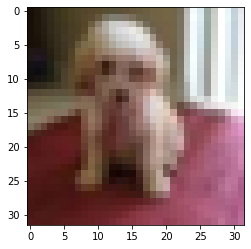

In [50]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 이미지크기 -> 채널 순으로 바꾸기
    plt.show()

 

def process():
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        custom_imshow(inputs[0])
        break

process()

In [83]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5, 120)  
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)  ## classes가 10개이기때문

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [84]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # momentum ==> 속도(?)

In [92]:
for epoch in range(1):
  running_loss = 0.0
  net.train()
  for i, data in enumerate(train_dl, 0):
    input, labels = data
    optimizer.zero_grad()
    outputs = net(input)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss:%.3f' %(epoch+1, i+1, running_loss / 2000))
      running_loss=0.0
  with torch.no_grad():
    net.eval()
    correct = 0
    total = 0
    for data in test_dl:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)  # == argmax() 가장 큰 자리값을 구하겠다.
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Val Accuracy:%d%%' %(100*correct/total))
print('Finisihed')

[1,  2000] loss:1.291
[1,  4000] loss:1.253
[1,  6000] loss:1.221
Val Accuracy:56%
Finisihed


In [93]:
with torch.no_grad():
  net.eval()
  correct = 0
  total = 0
  for data in test_dl:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # == argmax() 가장 큰 자리값을 구하겠다.
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Val Accuracy:%d%%' %(100*correct/total))
print('Finisihed')

Val Accuracy:56%
Finisihed


In [ ]:
# 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
        self.len = len(labels)
                    
    def __len__(self):
        return len
    
    def __getitem__(self, index):  # 데이터를 튜플형태로 내보낸다(getitem)
        data = self.X[index], self.y[index] # gets the row
        # reshape the row into the image size 
        # (numpy arrays have the color channels dim last)
        data = np.array(data).astype(np.uint8).reshape(28, 28, 1) 
        
        # perform transforms if there are any
        if self.transforms:
            data = self.transforms(data)
        
        # if !test_set return the label as well, otherwise don't
        if self.y is not None: # train/val
            return (data, self.y[i])
        else: # test
            return data

class ToTensor:  ## data 받기
  def __call__(self, data):
    x_data, y_data = data
    x_data = torch.FloatTensor(x_data)  # x_data 변환
    x_data = x.data.permute(2,0,1)  # x_data 채널수와 이미지 사이즈 순서 변환
    return x_data, torch.LongTensor(y_data)  # y_data LongTensor로 변환